# Identification of digits from sign language images 

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import relevant libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Image Settings
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2

In [4]:
# Define get images function
def get_img(data_path):
    # Getting image array from path:
    img = cv2.imread(data_path)
    img = cv2.resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img

## Analyze dataset

Number of samples for digit 0: 1230
Number of samples for digit 1: 1236
Number of samples for digit 2: 1236
Number of samples for digit 3: 1236
Number of samples for digit 4: 1242
Number of samples for digit 5: 1242
Number of samples for digit 6: 1242
Number of samples for digit 7: 1236
Number of samples for digit 8: 1248
Number of samples for digit 9: 1224


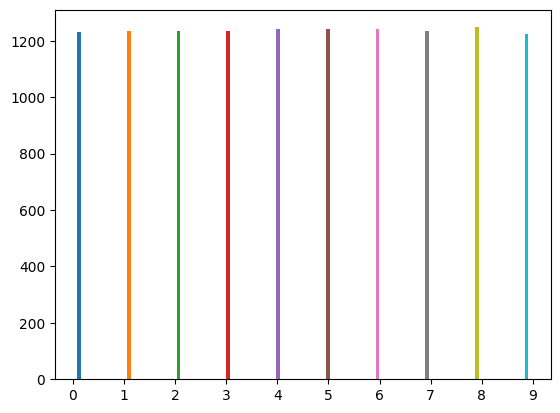

In [5]:
import imgaug.augmenters as iaa
# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20)),  # rotate image by -20 to 20 degrees
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # add Gaussian noise with std dev of 0 to 0.05*255
    iaa.GammaContrast((0.5, 1.5)),  # adjust gamma between 0.5 and 1.5
])

augment = False
# Plot the number of samples for each sign languagem digit
dataset_path = "dataset/augmented/"
data_distribution = {}

labels = os.listdir(dataset_path)  # Getting labels
labels.sort()  # Sorting labels
for i, label in enumerate(labels):
    data_path = dataset_path + label
    for img in os.listdir(data_path):
        img_path = data_path + "/" + img
        img_read = cv2.imread(img_path)

        if label in data_distribution:
            data_distribution[label].append(img_read)
        else:
            data_distribution[label] = [img_read]

        if augment:
            # Generate 5 augmented images
            augmented_images = seq.augment_images([img_read]*5)

            # Save the augmented images
            for i, augmented_image in enumerate(augmented_images):
                cv2.imwrite(f"{data_path}/{img}_augmented_image_{i}.jpg", augmented_image)
                data_distribution[label].append(augmented_image)
    

for label in data_distribution:
    print("Number of samples for digit " + label + ": " + str(len(data_distribution[label])))

#TODO: Plot a better histogram (label each bar with the total number of samples)
counts, edges, bars = plt.hist([[key]*len(data_distribution[key]) for key in data_distribution.keys()], bins=10)
plt.show()
        

- We have a pretty balanced dataset

## Data Preprocessing 

For the preprocessing we will be resizing and converting each image to grayscale. We will also be flatening them

In [6]:
# Resize function
def resize(img):
    width = 50
    height = 50
    dim = (width, height)

    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

# Convert image to grayscale
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

# Flatten image
def flatten(img):
    data = np.array(img)

    flattened = data.flatten()
    return flattened

In [7]:
# Define Save and Load Model functions

import pickle
def save_model(filename, model):
    pickle.dump(model, open("models/"+filename, 'wb'))

def load_model(filename):
    return pickle.load(open("models/"+filename, 'rb'))


In [8]:
# Deal with the dataset images

images = []
labels = []

for label in data_distribution:
    for img in data_distribution[label]:
        img_resized = resize(img)
        img_grayscale = grayscale(img_resized)
        img_flattened = flatten(img_grayscale)

        images.append(img_flattened)
        labels.append(label)
images = np.asarray(images)
labels = np.asarray(labels)

In [9]:
# Split data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=58)   

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(9897, 2500) (9897,)
(2475, 2500) (2475,)


In [10]:
# Define train and analyse model functions
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def train_and_analyze(model, X_train, y_train, X_test, y_test):
    trained_model = model.fit(X_train, y_train)
    
    print(f"> Model: {model.__class__}\n")
    
    X_test_prediction = model.predict(X_test)
    test_data_accuracy = accuracy_score(X_test_prediction, y_test)
    f1 = f1_score(y_test, X_test_prediction, average='weighted')

    print()
    print("---- Model Analysis ----")
    print('Accuracy: ', test_data_accuracy)
    print('F1 Score: ', f1)
    
    print()
    
    print("Confusion Matrix: ")
    cm = confusion_matrix(y_test, model.predict(X_test))
    plot_confusion_matrix(cm, target_names=[str(i) for i in range(10)], normalize=False)
    plt.show()
    
    print()
    print("---- Classification Report ----")
    print(classification_report(y_test, model.predict(X_test)))

    return trained_model

def hyperparameters(model, params, X, y):
    """
    Find hyperparameters for a model
    """
    print("> Hyper Parameter Tuning")
    print("Finding Best Params for Model ", model.__class__)
    model = GridSearchCV(model, params, scoring="accuracy")
    model.fit(X, y)
    print(" Best Params: ")
    print(model.best_params_)
    
    return model.best_params_


def kfold(model, k, X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X_train, y_train, scoring="accuracy", cv=k, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]

# Basic Models without Parameter Tuning

## Logistic Regression

> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


---- Model Analysis ----
Accuracy:  0.7503030303030302
F1 Score:  0.7498624742269093

Confusion Matrix: 


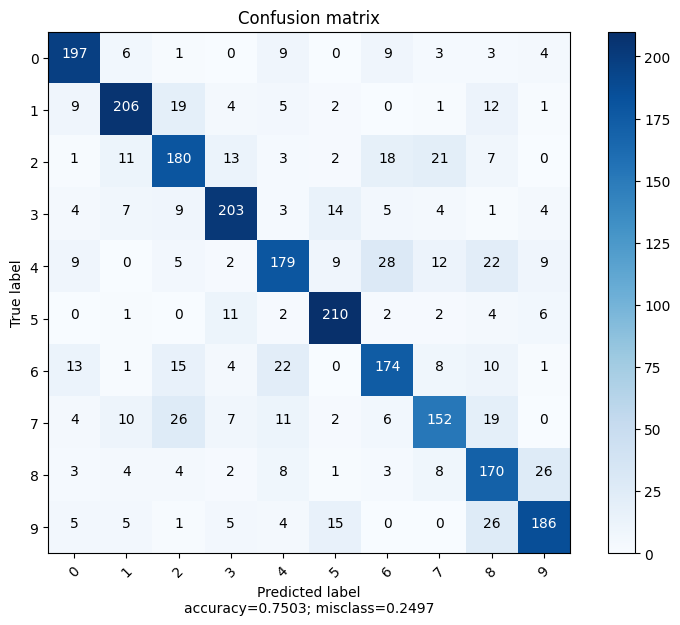


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       232
           1       0.82      0.80      0.81       259
           2       0.69      0.70      0.70       256
           3       0.81      0.80      0.80       254
           4       0.73      0.65      0.69       275
           5       0.82      0.88      0.85       238
           6       0.71      0.70      0.71       248
           7       0.72      0.64      0.68       237
           8       0.62      0.74      0.68       229
           9       0.78      0.75      0.77       247

    accuracy                           0.75      2475
   macro avg       0.75      0.75      0.75      2475
weighted avg       0.75      0.75      0.75      2475



In [28]:
from sklearn.linear_model import LogisticRegression
logisticRegr = train_and_analyze(LogisticRegression(), x_train, y_train, x_test, y_test)

save_model("logistic_regression.sav", logisticRegr)

## Decision Tree Model

> Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>


---- Model Analysis ----
Accuracy:  0.6311111111111111
F1 Score:  0.6318439865414431

Confusion Matrix: 


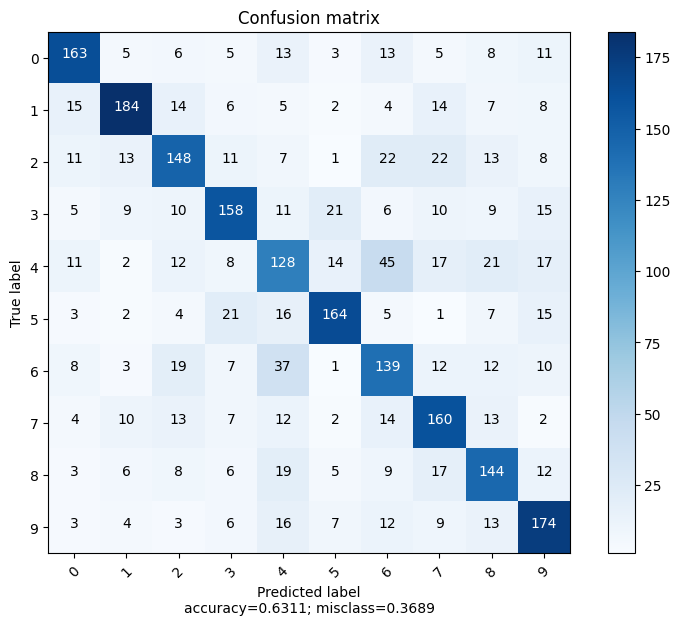


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       232
           1       0.77      0.71      0.74       259
           2       0.62      0.58      0.60       256
           3       0.67      0.62      0.65       254
           4       0.48      0.47      0.47       275
           5       0.75      0.69      0.72       238
           6       0.52      0.56      0.54       248
           7       0.60      0.68      0.63       237
           8       0.58      0.63      0.61       229
           9       0.64      0.70      0.67       247

    accuracy                           0.63      2475
   macro avg       0.64      0.63      0.63      2475
weighted avg       0.63      0.63      0.63      2475



In [29]:
from sklearn import tree
clf = train_and_analyze(tree.DecisionTreeClassifier(), x_train, y_train, x_test, y_test)

save_model("decision_tree.sav", clf)


## Random Forest Classifier

> Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


---- Model Analysis ----
Accuracy:  0.8763636363636363
F1 Score:  0.8760581895636548

Confusion Matrix: 


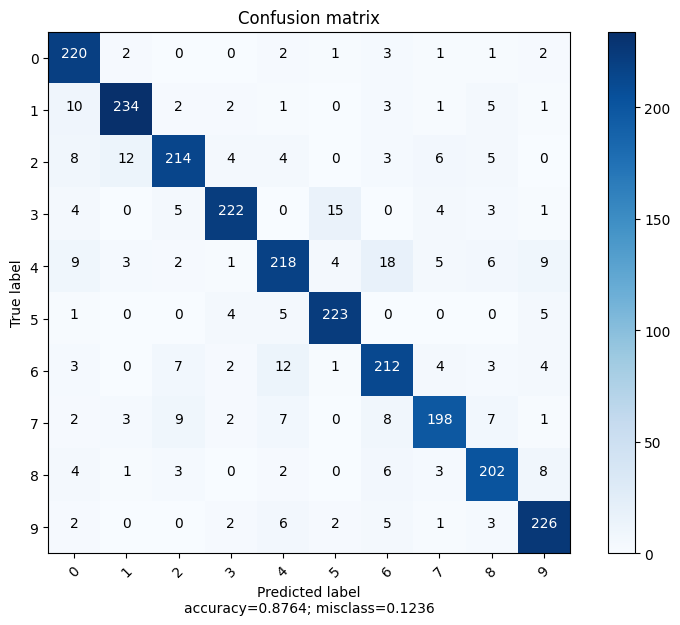


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       232
           1       0.92      0.90      0.91       259
           2       0.88      0.84      0.86       256
           3       0.93      0.87      0.90       254
           4       0.85      0.79      0.82       275
           5       0.91      0.94      0.92       238
           6       0.82      0.85      0.84       248
           7       0.89      0.84      0.86       237
           8       0.86      0.88      0.87       229
           9       0.88      0.91      0.90       247

    accuracy                           0.88      2475
   macro avg       0.88      0.88      0.88      2475
weighted avg       0.88      0.88      0.88      2475



In [15]:
from sklearn.ensemble import RandomForestClassifier
clf_rft = train_and_analyze(RandomForestClassifier(), x_train, y_train, x_test, y_test)

save_model("random_forest.sav", clf_rft)


## Naive Bayes

> Model: <class 'sklearn.naive_bayes.GaussianNB'>


---- Model Analysis ----
Accuracy:  0.5026262626262626
F1 Score:  0.5062376721593332

Confusion Matrix: 


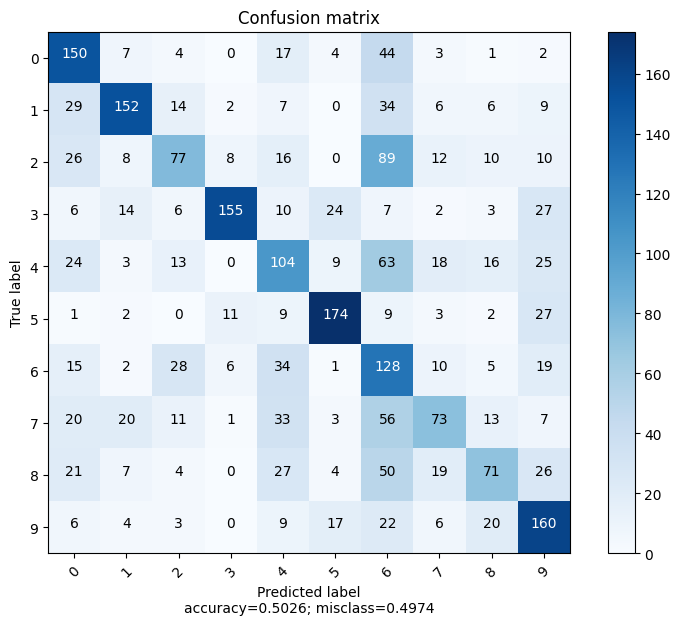


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.50      0.65      0.57       232
           1       0.69      0.59      0.64       259
           2       0.48      0.30      0.37       256
           3       0.85      0.61      0.71       254
           4       0.39      0.38      0.38       275
           5       0.74      0.73      0.73       238
           6       0.25      0.52      0.34       248
           7       0.48      0.31      0.38       237
           8       0.48      0.31      0.38       229
           9       0.51      0.65      0.57       247

    accuracy                           0.50      2475
   macro avg       0.54      0.50      0.51      2475
weighted avg       0.54      0.50      0.51      2475



In [31]:
from sklearn.naive_bayes import GaussianNB 
gnb = train_and_analyze(GaussianNB(), x_train, y_train, x_test, y_test)

save_model("naive_bayes.sav", gnb)

## SVM

> Model: <class 'sklearn.svm._classes.SVC'>


---- Model Analysis ----
Accuracy:  0.8884848484848484
F1 Score:  0.8884637574580185

Confusion Matrix: 


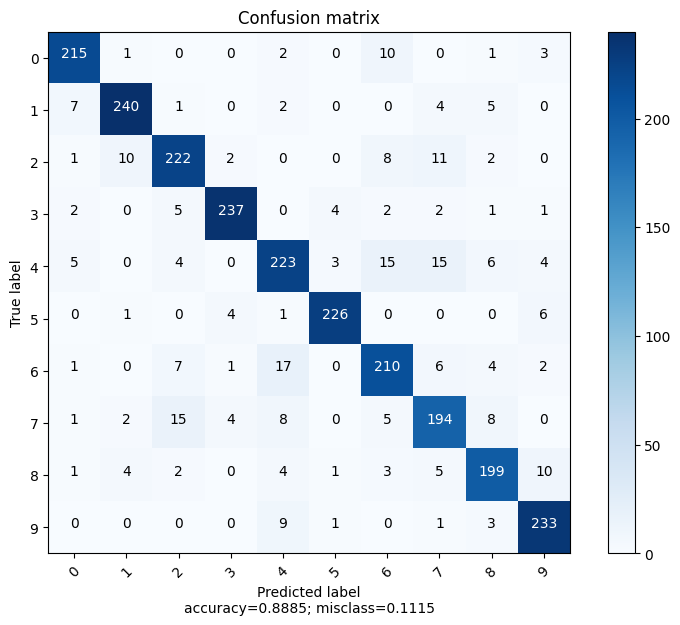


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       232
           1       0.93      0.93      0.93       259
           2       0.87      0.87      0.87       256
           3       0.96      0.93      0.94       254
           4       0.84      0.81      0.82       275
           5       0.96      0.95      0.96       238
           6       0.83      0.85      0.84       248
           7       0.82      0.82      0.82       237
           8       0.87      0.87      0.87       229
           9       0.90      0.94      0.92       247

    accuracy                           0.89      2475
   macro avg       0.89      0.89      0.89      2475
weighted avg       0.89      0.89      0.89      2475



In [16]:
from sklearn.svm import SVC

svm = train_and_analyze(SVC(), x_train, y_train, x_test, y_test)

save_model("svm.sav", svm) 


## Neural Networks 

> Model: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


---- Model Analysis ----
Accuracy:  0.09252525252525252
F1 Score:  0.01567180682565298

Confusion Matrix: 


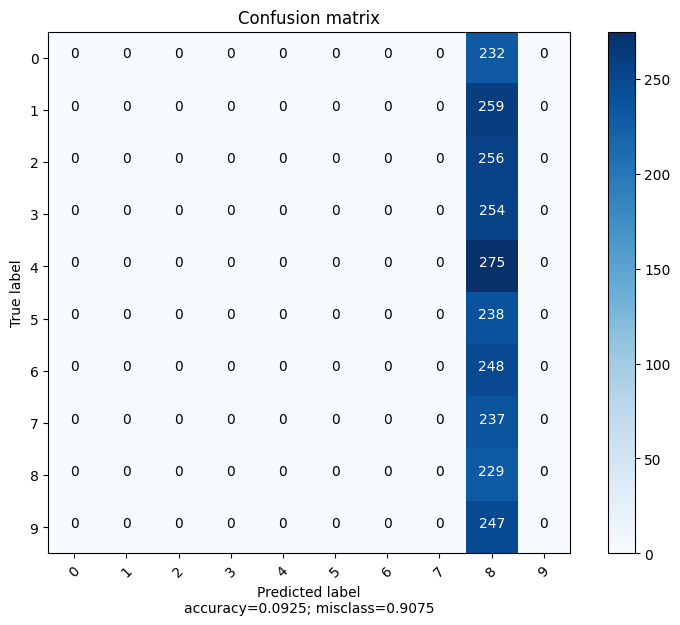


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       232
           1       0.00      0.00      0.00       259
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       254
           4       0.00      0.00      0.00       275
           5       0.00      0.00      0.00       238
           6       0.00      0.00      0.00       248
           7       0.00      0.00      0.00       237
           8       0.09      1.00      0.17       229
           9       0.00      0.00      0.00       247

    accuracy                           0.09      2475
   macro avg       0.01      0.10      0.02      2475
weighted avg       0.01      0.09      0.02      2475



In [17]:
from sklearn.neural_network import MLPClassifier

NN = train_and_analyze(MLPClassifier(), x_train, y_train, x_test, y_test)

save_model("neural_network.sav", NN)

## Gradient Descent Classifier

## Models with Hypertuned Parameters & Cross-Validation

## Logistic Regression

In [34]:
hypertuned_model = LogisticRegression()

logreg_params = [{'solver': ['liblinear'], 'max_iter': [100, 400, 800],
                         'C': [0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']}]
best_logreg_params = hyperparameters(LogisticRegression(), logreg_params , x_train, y_train)
hypertuned_model.set_params(**best_logreg_params)

hypertuned_model = train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)

save_model("/tuned/logistic_regression_tuned.sav", hypertuned_model)

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.linear_model._logistic.LogisticRegression'>


> Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>


---- Model Analysis ----
Accuracy:  0.7046004842615012
F1 Score:  0.7110676780769706

Confusion Matrix: 


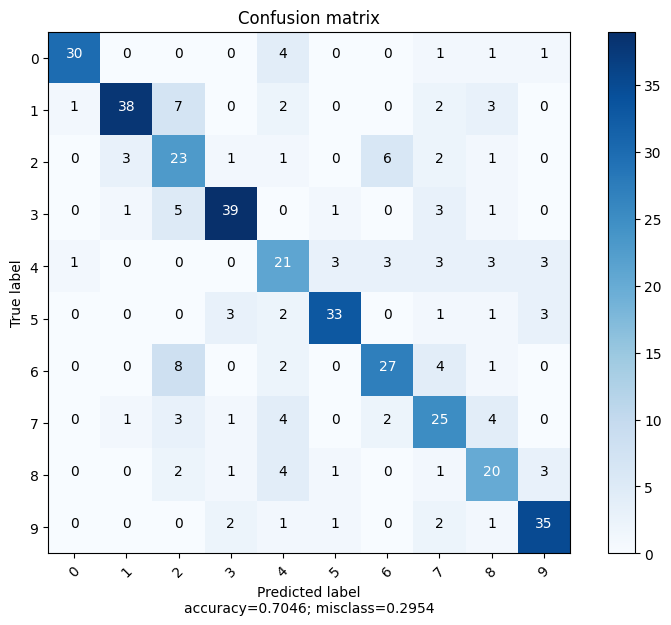


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        37
           1       0.88      0.72      0.79        53
           2       0.48      0.62      0.54        37
           3       0.83      0.78      0.80        50
           4       0.51      0.57      0.54        37
           5       0.85      0.77      0.80        43
           6       0.71      0.64      0.67        42
           7       0.57      0.62      0.60        40
           8       0.56      0.62      0.59        32
           9       0.78      0.83      0.80        42

    accuracy                           0.70       413
   macro avg       0.71      0.70      0.70       413
weighted avg       0.72      0.70      0.71       413



In [ ]:
logreg_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

logreg_kfmodel = train_and_analyze(logreg_kfmodel, x_train, y_train, x_test, y_test)

save_model("/CV/logistic_regression_cv.sav", logreg_kfmodel)

In [19]:
print(best_svm_parameters)

{'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


## SVM

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.svm._classes.SVC'>
 Best Params: 
{'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
> Model: <class 'sklearn.svm._classes.SVC'>


---- Model Analysis ----
Accuracy:  0.9503030303030303
F1 Score:  0.9502587459731121

Confusion Matrix: 


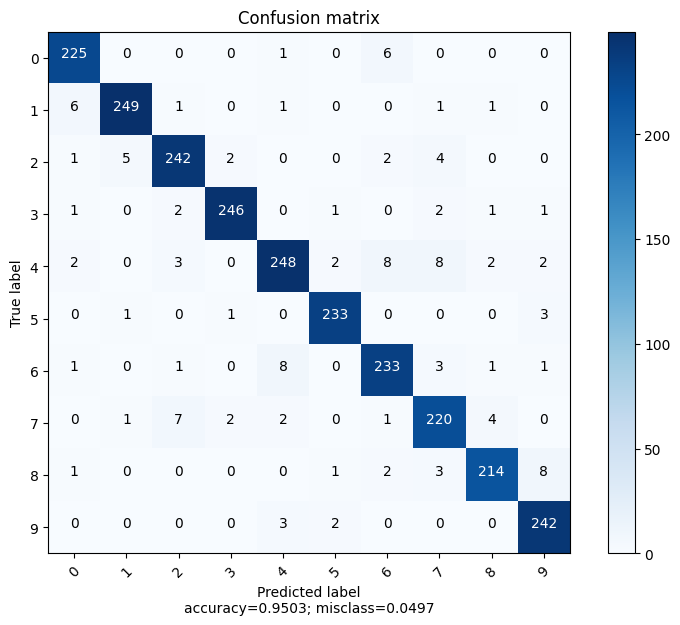


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       232
           1       0.97      0.96      0.97       259
           2       0.95      0.95      0.95       256
           3       0.98      0.97      0.97       254
           4       0.94      0.90      0.92       275
           5       0.97      0.98      0.98       238
           6       0.92      0.94      0.93       248
           7       0.91      0.93      0.92       237
           8       0.96      0.93      0.95       229
           9       0.94      0.98      0.96       247

    accuracy                           0.95      2475
   macro avg       0.95      0.95      0.95      2475
weighted avg       0.95      0.95      0.95      2475



FileNotFoundError: [Errno 2] No such file or directory: 'models//tuned/SVM_tuned.sav'

In [18]:


hypertuned_model = SVC()

svm_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                   'degree': [2, 3, 4, 5],
                   'gamma': ['scale', 'auto']}] 
best_svm_parameters = hyperparameters(SVC(), svm_parameters , x_train, y_train)
hypertuned_model.set_params(**best_svm_parameters)


hypertuned_model = train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)

save_model("/tuned/SVM_tuned.sav", hypertuned_model)

> Model: <class 'sklearn.svm._classes.SVC'>


---- Model Analysis ----
Accuracy:  0.9503030303030303
F1 Score:  0.9502587459731121

Confusion Matrix: 


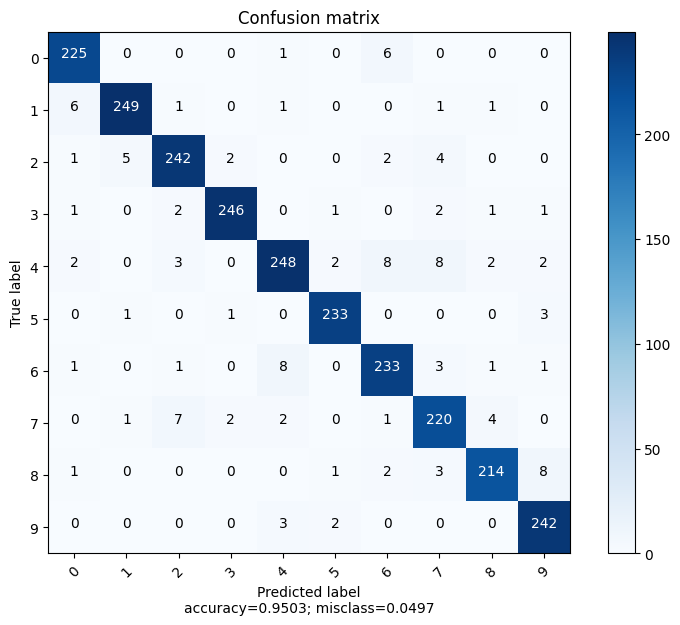


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       232
           1       0.97      0.96      0.97       259
           2       0.95      0.95      0.95       256
           3       0.98      0.97      0.97       254
           4       0.94      0.90      0.92       275
           5       0.97      0.98      0.98       238
           6       0.92      0.94      0.93       248
           7       0.91      0.93      0.92       237
           8       0.96      0.93      0.95       229
           9       0.94      0.98      0.96       247

    accuracy                           0.95      2475
   macro avg       0.95      0.95      0.95      2475
weighted avg       0.95      0.95      0.95      2475

> Model: <class 'sklearn.svm._classes.SVC'>


---- Model Analysis ----
Accuracy:  0.9503030303030303
F1 Score:  0.9502587459731121

Confusion Matrix: 


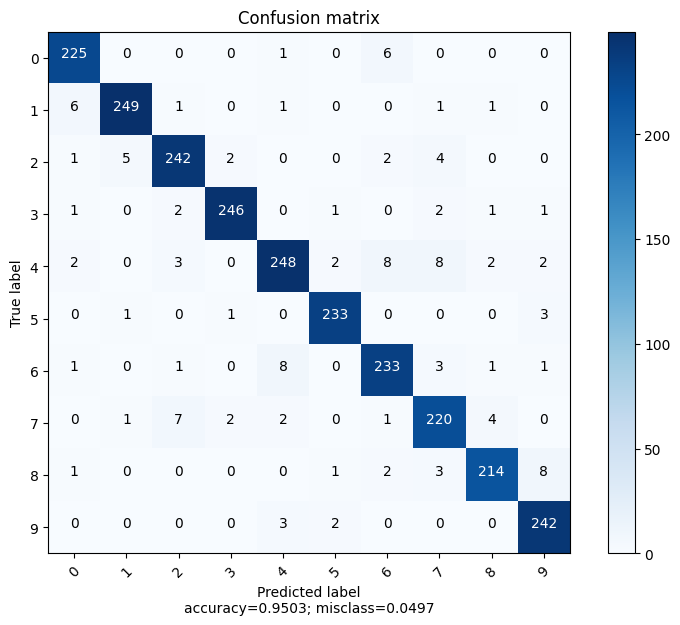


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       232
           1       0.97      0.96      0.97       259
           2       0.95      0.95      0.95       256
           3       0.98      0.97      0.97       254
           4       0.94      0.90      0.92       275
           5       0.97      0.98      0.98       238
           6       0.92      0.94      0.93       248
           7       0.91      0.93      0.92       237
           8       0.96      0.93      0.95       229
           9       0.94      0.98      0.96       247

    accuracy                           0.95      2475
   macro avg       0.95      0.95      0.95      2475
weighted avg       0.95      0.95      0.95      2475



In [20]:
'''{'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}'''
#Run with the best parameters
svm_kfmodel = train_and_analyze(SVC(C=100, degree=2, gamma='scale', kernel='rbf'), x_train, y_train, x_test, y_test)

svm_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

svm_kfmodel = train_and_analyze(svm_kfmodel, x_train, y_train, x_test, y_test)

In [ ]:
svm_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

svm_kfmodel = train_and_analyze(svm_kfmodel, x_train, y_train, x_test, y_test)

save_model("/CV/svm_cv.sav", svm_kfmodel)

NameError: name 'kfold' is not defined

## Neural Networks

> Model: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


---- Model Analysis ----
Accuracy:  0.09252525252525252
F1 Score:  0.01567180682565298

Confusion Matrix: 


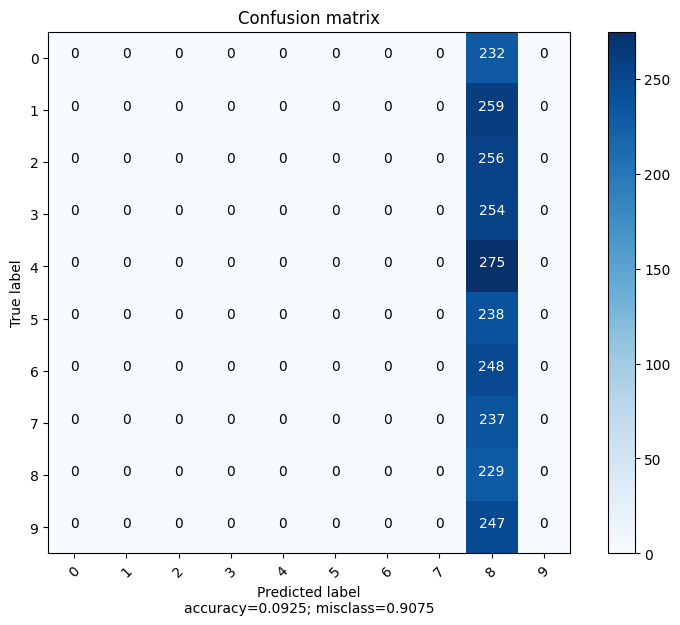


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       232
           1       0.00      0.00      0.00       259
           2       0.00      0.00      0.00       256
           3       0.00      0.00      0.00       254
           4       0.00      0.00      0.00       275
           5       0.00      0.00      0.00       238
           6       0.00      0.00      0.00       248
           7       0.00      0.00      0.00       237
           8       0.09      1.00      0.17       229
           9       0.00      0.00      0.00       247

    accuracy                           0.09      2475
   macro avg       0.01      0.10      0.02      2475
weighted avg       0.01      0.09      0.02      2475



MLPClassifier(hidden_layer_sizes=(256,), learning_rate_init=0.01, max_iter=1000)

In [15]:

nn_parameters = [{'solver': ['adam', 'lbfgs'], 
                  'max_iter': [1000],
                  'hidden_layer_sizes': [(128,), (256,), (512,), (128, 128), (256, 256), (512, 512)],
                  'activation': ['relu', 'tanh'], 
                  'alpha': [0.0001, 0.001, 0.01],
                  'learning_rate': ['constant', 'invscaling', 'adaptive'], 
                  'learning_rate_init': [0.001, 0.01, 0.1]}]
from sklearn.neural_network import MLPClassifier

parameter = {'solver':'adam', 
                  'max_iter': 1000,
                  'hidden_layer_sizes': (256,),
                  'activation': 'relu', 
                  'alpha': 0.0001,
                  'learning_rate': 'constant', 
                  'learning_rate_init': 0.01}
model = MLPClassifier()
model.set_params(**parameter)
train_and_analyze(model, x_train, y_train, x_test, y_test)



In [16]:
hypertuned_model = MLPClassifier()

nn_parameters = [{'solver': ['adam', 'lbfgs'], 
                  'max_iter': [1000],
                  'hidden_layer_sizes': [(128,), (256,), (512,), (128, 128), (256, 256), (512, 512)],
                  'activation': ['relu', 'tanh'], 
                  'alpha': [0.0001, 0.001, 0.01],
                  'learning_rate': ['constant', 'invscaling', 'adaptive'], 
                  'learning_rate_init': [0.001, 0.01, 0.1]}]


best_nn_parameters = hyperparameters(MLPClassifier(), nn_parameters , x_train, y_train)
hypertuned_model.set_params(**best_nn_parameters)

hypertuned_model = train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)

print(best_nn_parameters)

# save_model("/tuned/NN_tuned.sav", hypertuned_model)

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


KeyboardInterrupt: 

> Model: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


---- Model Analysis ----
Accuracy:  0.0774818401937046
F1 Score:  0.011143455668308079

Confusion Matrix: 


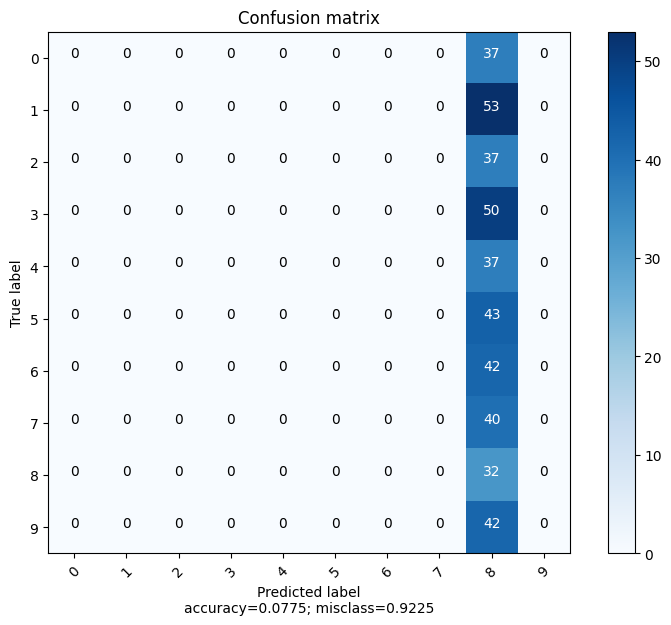


---- Classification Report ----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        53
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        43
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00        40
           8       0.08      1.00      0.14        32
           9       0.00      0.00      0.00        42

    accuracy                           0.08       413
   macro avg       0.01      0.10      0.01       413
weighted avg       0.01      0.08      0.01       413



In [ ]:
nn_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

nn_kfmodel = train_and_analyze(nn_kfmodel, x_train, y_train, x_test, y_test)

save_model("/CV/nn_cv.sav", nn_kfmodel)

## Random Forest Classifier

In [ ]:
hypertuned_model = RandomForestClassifier()

rf_parameters = {
    'n_estimators': [50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

best_rf_parameters = hyperparameters(RandomForestClassifier(), rf_parameters , x_train, y_train)
hypertuned_model.set_params(**best_rf_parameters)

hypertuned_model = train_and_analyze(hypertuned_model, x_train, y_train, x_test, y_test)

save_model("/tuned/rf_tuned.sav", hypertuned_model)

> Hyper Parameter Tuning
Finding Best Params for Model  <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [ ]:
rf_kfmodel = kfold(hypertuned_model, 5, x_train, y_train, x_test, y_test)

rf_kfmodel = train_and_analyze(rf_kfmodel, x_train, y_train, x_test, y_test)

save_model("/CV/rf_cv.sav", rf_kfmodel)